In [ ]:
pip install git+https://github.com/ssut/py-hanspell.git

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 적용
plt.rc('font', family='Malgun Gothic') 
# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (12, 9)


from hanspell import spell_checker
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('../input/train.csv', dtype=str)
valid = pd.read_csv('../input/validation.csv', dtype=str)
test = pd.read_csv('../input/test.csv', dtype=str)


In [3]:
print(train.info(), "\n")
print(valid.info(), "\n")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65299 entries, 0 to 65298
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  65299 non-null  object
 1   intent     65299 non-null  object
dtypes: object(2)
memory usage: 1020.4+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10872 entries, 0 to 10871
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  10872 non-null  object
 1   intent     10872 non-null  object
dtypes: object(2)
memory usage: 170.0+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8481 entries, 0 to 8480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  8481 non-null   object
 1   intent     8481 non-null   object
dtypes: object(2)
memory usage: 132.6+ KB
None


In [4]:
dfs = { 
    'train': {
        'data' : train
    }, 
    'valid': {
        'data' : valid
    } , 
    'test': {
        'data' : test
    } 
}

### 전처리

In [5]:
# na값 확인
print(train.isna().values.any())
print(valid.isna().values.any())
print(test.isna().values.any())

False
False
False


In [6]:
# 결측치 확인 및 제거
for dfName in dfs.keys():
    # 빈값 제거 
    print(len(dfs[dfName]['data']))
    dfs[dfName]['data'].replace("", float("NaN"), inplace=True)
    dfs[dfName]['data'].dropna(inplace=True)
    print(dfs[dfName]['data'].isnull().values.any())
    print(len(dfs[dfName]['data']))
    
    print("\n")

65299
False
65299


10872
False
10872


8481
False
8481




In [7]:
print('중복을 제외한 train의 utterance  : {}'.format(train['utterance'].nunique()))
print('중복을 제외한 train의 intent     : {}'.format(train['intent'].nunique()))
print('중복을 제외한 valid의 utterance  : {}'.format(valid['utterance'].nunique()))
print('중복을 제외한 valid의 intent     : {}'.format(valid['intent'].nunique()))
print('중복을 제외한 test의 utterance  : {}'.format(test['utterance'].nunique()))
print('중복을 제외한 test의 intent     : {}'.format(test['intent'].nunique()))

중복을 제외한 train의 utterance  : 65284
중복을 제외한 train의 intent     : 13
중복을 제외한 valid의 utterance  : 10872
중복을 제외한 valid의 intent     : 13
중복을 제외한 test의 utterance  : 8481
중복을 제외한 test의 intent     : 13


In [8]:
train['intent'].value_counts().sort_values(ascending=False)

제품          41635
배송          15744
교환|반품|환불     2431
행사           1895
결제           1214
AS            839
구매            423
웹사이트          303
부가서비스         269
포장            253
매장            202
주문             53
멤버십            38
Name: intent, dtype: int64

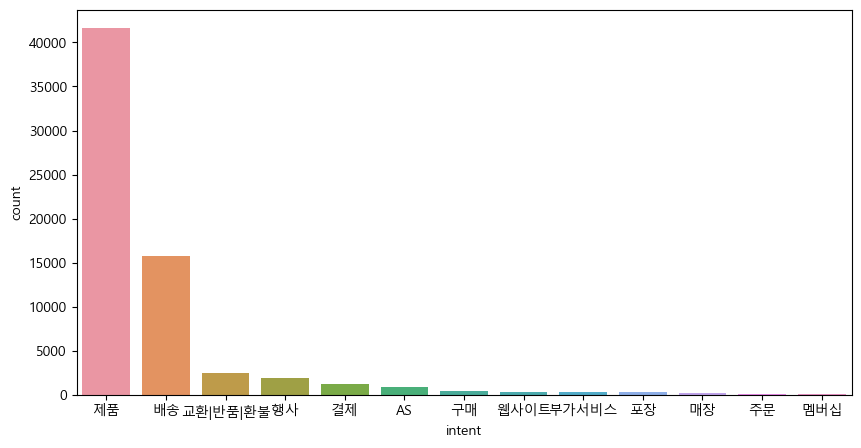

In [9]:
order = train['intent'].value_counts().sort_values(ascending=False).index

fig = plt.figure(figsize=(10,5))
sns.countplot(data = train, x = 'intent', order=order)
plt.show()


#### 토큰화 전 맞춤법 보정

In [10]:
# 맞춤법 보정
def spellCheck(sent):
    sent = sent.replace(" ", "")
    spelled_sent = spell_checker.check(sent)
    hanspell_sent = spelled_sent.checked
    return hanspell_sent

In [11]:
sent = train['utterance'][65296]
nsSent = sent.replace(" ", "")

print("nsSent               : ", nsSent)

spelled_sent = spell_checker.check(sent)
hanspell_sent = spelled_sent.checked
print("hanspell_sent        : ", hanspell_sent)

nsSent               :  세트구성에는4060이던데그사이즈는필요없어서5070으로일단추가구매했는데둘다보내는건가여?
hanspell_sent        :  세트 구성에는 40 60이던데 그 사이즈는 필요 없어서 50 70으로 일단 추가 구매했는데 둘 다 보내는 건가요?


In [ ]:
train['sentence'] = train['utterance'].apply(spellCheck)
train.to_csv('../input/train2.csv', sep=',', index = True)
valid['sentence'] = valid['utterance'].apply(spellCheck)
valid.to_csv('../input/valid2.csv', sep=',', index = True)
test['sentence'] = test['utterance'].apply(spellCheck)
test.to_csv('../input/test2.csv', sep=',', index = True)

In [577]:
train = pd.read_csv('../input/train2.csv', dtype=str)
valid = pd.read_csv('../input/valid2.csv', dtype=str)
test = pd.read_csv('../input/test2.csv', dtype=str)


#### 정수 인코딩 

In [583]:
encoder = LabelEncoder()
train_intent = train['intent']
valid_intent = valid['intent']
test_intent = test['intent']

# X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
encoder.fit(train_intent)
X_train_encoded = encoder.transform(train_intent)

# X_test데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가
for item in [np.unique(valid_intent), np.unique(test_intent)]:
    for label in item:
        if label not in encoder.classes_: # unseen label 데이터인 경우( )
            encoder.classes_ = np.append(encoder.classes_, label) # 미처리 시 ValueError발생
X_valid_encoded = encoder.transform(valid_intent)
X_test_encoded = encoder.transform(test_intent)


In [584]:
train['target'] = X_train_encoded
valid['target'] = X_valid_encoded
test['target'] = X_test_encoded

In [585]:
train_sentence = train['sentence']
train_label = train['target']
valid_sentence = valid['sentence']
valid_label = valid['target']
test_sentence = test['sentence']
test_label = test['target']

vocab_size = int(40000)
num_classes = train['target'].nunique()


print(f"len(train): {len(train)}, len(train_sentence): {len(train_sentence)}, vocab_size: {vocab_size}")

len(train): 65299, len(train_sentence): 65299, vocab_size: 40000


#### 토큰화

In [586]:
tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용
tokenizer.fit_on_texts(train_sentence)
X_train = tokenizer.texts_to_sequences(train_sentence) # 샘플 수 × vocab_size 크기의 행렬 생성
X_valid = tokenizer.texts_to_sequences(valid_sentence) # 샘플 수 × vocab_size 크기의 행렬 생성
X_test = tokenizer.texts_to_sequences(test_sentence) # 샘플 수 × vocab_size 크기의 행렬 생성
y_train = train_label
y_valid = valid_label
y_test = test_label

In [587]:
len(tokenizer.word_index)

80851

In [599]:
print('train 샘플 본문의 크기 : {}'.format(len(X_train)))
print('train 샘플 레이블의 크기 : {}'.format(len(y_train)))
print('valid 샘플 본문의 크기 : {}'.format(len(X_valid)))
print('valid 샘플 레이블의 크기 : {}'.format(len(y_valid)))
print('test  샘플 본문의 크기 : {}'.format(len(X_test)))
print('test  샘플 레이블의 크기 : {}'.format(len(y_test)))


train 샘플 본문의 크기 : 65299
train 샘플 레이블의 크기 : 65299
valid 샘플 본문의 크기 : 10872
valid 샘플 레이블의 크기 : 10872
test  샘플 본문의 크기 : 8481
test  샘플 레이블의 크기 : 8481


In [502]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12]
 [ 168  225  521   82   43   10 3164   62   71 8250   10   35  418]]


In [503]:
encoder.classes_

array(['AS', '결제', '교환|반품|환불', '구매', '매장', '멤버십', '배송', '부가서비스', '웹사이트',
       '제품', '주문', '포장', '행사'], dtype=object)

In [93]:
encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

array(['AS', '결제', '교환|반품|환불', '구매', '매장', '멤버십', '배송', '부가서비스', '웹사이트',
       '제품', '주문', '포장', '행사'], dtype=object)

sentence의 최대 길이 :85
sentence의 평균 길이 :7.156434248610239


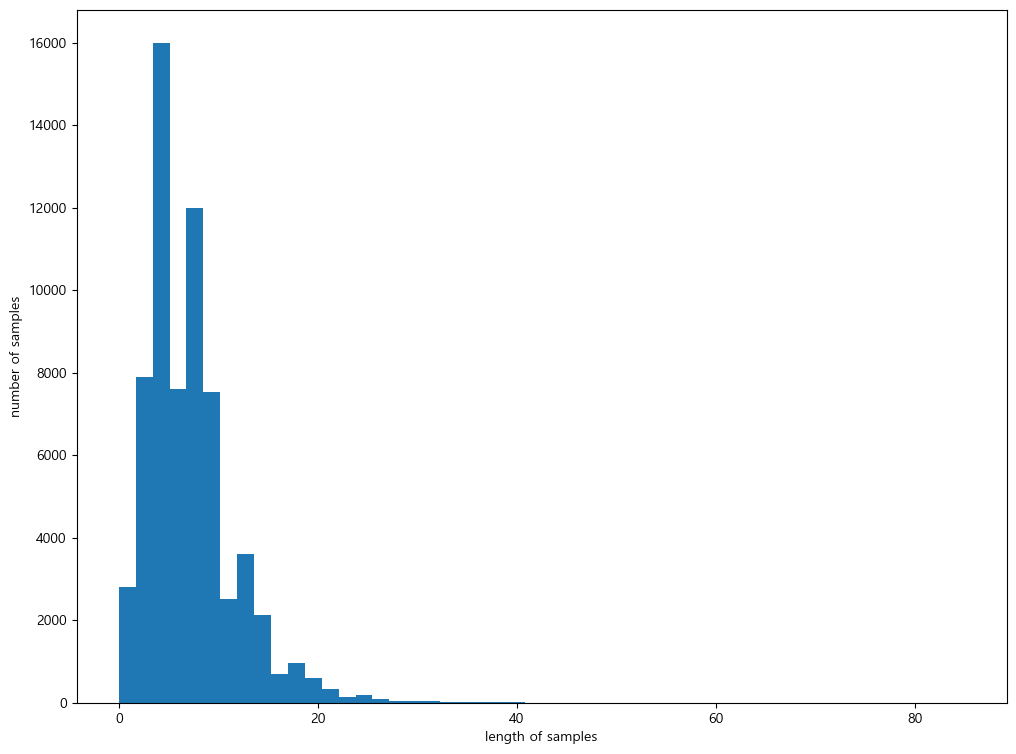

In [589]:
max_len = max(len(sample) for sample in X_train)
print('sentence의 최대 길이 :{}'.format(max_len))
print('sentence의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


### LSTM

####  modeling

In [591]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


vocab_size = vocab_size
max_len = max_len

X_train = pad_sequences(X_train, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)


In [276]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score


In [604]:
embedding_dim = 128
hidden_units = 256
num_classes = num_classes
batch_size = 128
epochs = 30
verbose = 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, dropout=0.3))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', precision, recall, f1score])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[es, mc], validation_data=(X_valid, y_valid))


Epoch 1/30
511/511 [==============================] - ETA: 0s - loss: 0.7020 - acc: 0.8095 - precision: 0.8425 - recall: 0.7726 - f1score: 0.8051
Epoch 1: val_acc improved from -inf to 0.86672, saving model to best_model.h5
511/511 [==============================] - 339s 660ms/step - loss: 0.7020 - acc: 0.8095 - precision: 0.8425 - recall: 0.7726 - f1score: 0.8051 - val_loss: 0.5423 - val_acc: 0.8667 - val_precision: 0.8948 - val_recall: 0.8492 - val_f1score: 0.8713
Epoch 2/30
511/511 [==============================] - ETA: 0s - loss: 0.4190 - acc: 0.8908 - precision: 0.9233 - recall: 0.8681 - f1score: 0.8947
Epoch 2: val_acc improved from 0.86672 to 0.87739, saving model to best_model.h5
511/511 [==============================] - 358s 701ms/step - loss: 0.4190 - acc: 0.8908 - precision: 0.9233 - recall: 0.8681 - f1score: 0.8947 - val_loss: 0.4853 - val_acc: 0.8774 - val_precision: 0.8999 - val_recall: 0.8618 - val_f1score: 0.8804
Epoch 3/30
511/511 [==============================] - E

#### evaluate

In [605]:
_loss, _acc, _precision, _recall, _f1score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))


67/67 - 10s - loss: 0.6371 - acc: 0.8589 - precision: 0.8721 - recall: 0.8499 - f1score: 0.8608 - 10s/epoch - 153ms/step
loss: 0.637, accuracy: 0.859, precision: 0.872, recall: 0.850, f1score: 0.861


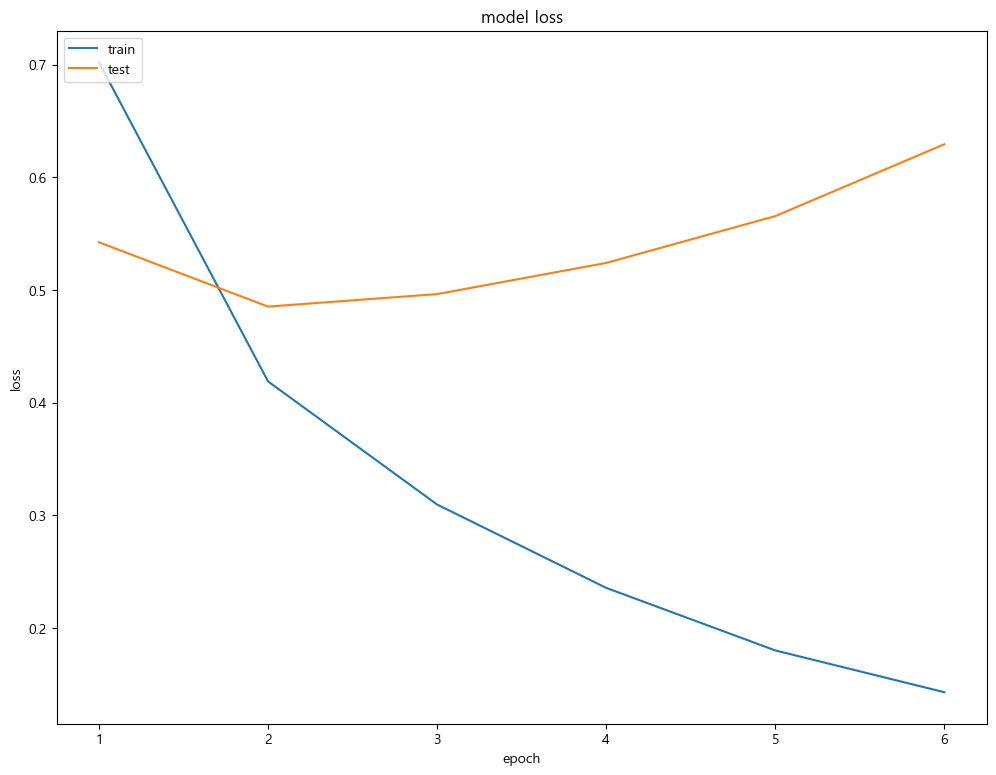

In [606]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [460]:
from sklearn.metrics import classification_report


In [608]:
y_predicted = np.argmax(model.predict(y_test), axis=1).tolist()
print(classification_report(np.argmax(y_test, axis=1).tolist(), y_predicted, target_names=encoder.classes_))


              precision    recall  f1-score   support

          AS       0.00      0.00      0.00       116
          결제       0.00      0.00      0.00       115
    교환|반품|환불       0.00      0.00      0.00       345
          구매       0.00      0.00      0.00        68
          매장       0.00      0.00      0.00        28
         멤버십       0.00      0.00      0.00         3
          배송       0.00      0.00      0.00      1932
       부가서비스       0.00      0.00      0.00        57
        웹사이트       0.00      0.00      0.00        58
          제품       0.63      1.00      0.78      5377
          주문       0.00      0.00      0.00        13
          포장       0.00      0.00      0.00        42
          행사       0.00      0.00      0.00       327

    accuracy                           0.63      8481
   macro avg       0.05      0.08      0.06      8481
weighted avg       0.40      0.63      0.49      8481



C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [620]:
dic = {'utterance' : test['utterance'], 'intent':encoder.inverse_transform(y_predicted)}
submission = pd.DataFrame(dic)
submission.to_csv('../output/submission.csv', sep=',', index = None, encoding='ms949')

266/266 [==============================] - 4s 14ms/step
